In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#Installing dependencies
!pip install music21
!apt-get install -y lilypond

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
lilypond is already the newest version (2.22.1-2).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [3]:
#Importing Libraries
import tensorflow
import numpy as np
import pandas as pd
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

In [4]:
#Loading the list of chopin's midi files as stream
filepath = "/content/drive/MyDrive/classical_midi_dataset/chopin/"
#Getting midi files
all_midis= []
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        tr = filepath+i
        midi = converter.parse(tr)
        all_midis.append(midi)

In [5]:
#Function to get the notes
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes
#Getting the list of notes as Corpus
Corpus= extract_notes(all_midis)
print("Total notes in all the Chopin midis in the dataset:", len(Corpus))

Total notes in all the Chopin midis in the dataset: 57894


In [6]:
# Printing the first 50 values in the corpus
print("First fifty values in the Corpus:", Corpus[:50])

First fifty values in the Corpus: ['E-3', 'E-2', 'B-3', 'B-2', 'F#3', 'F#2', 'B3', 'B2', 'E-3', 'E-2', 'B3', 'B2', 'D3', 'D2', 'B3', 'B2', 'F3', 'F2', 'B-3', 'B-2', 'D3', 'D2', 'B-3', 'B-2', 'E-3', 'E-2', 'B-3', 'B-2', 'F#3', 'F#2', 'B3', 'B2', 'E-3', 'E-2', 'B3', 'B2', 'D3', 'D2', 'B3', 'B2', 'F3', 'F2', 'B-3', 'B-2', 'D3', 'D2', 'B-3', 'B-2', 'E-3', 'E-2']


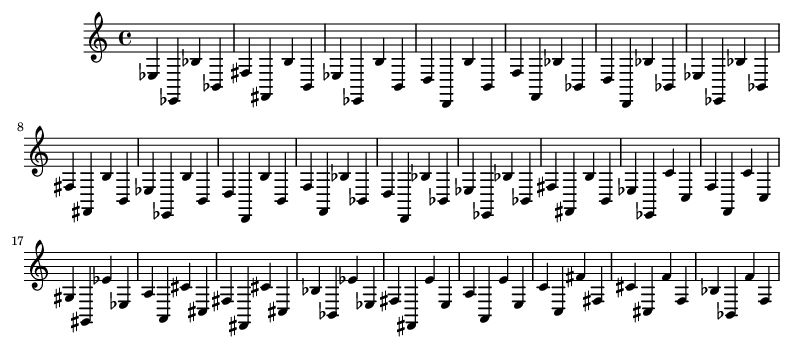

In [7]:
# Printing the music sheet
#First Lets write some functions that we need to look into the data
def show(music):
    display(Image(str(music.write("lily.png"))))

def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = []
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else:
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)
    return Melody_midi

Melody_Snippet = chords_n_notes(Corpus[:100])
show(Melody_Snippet)


In [8]:
# Creating a count dictionary
count_num = Counter(Corpus)
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 397


In [9]:
#Exploring the notes dictionary
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
#Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrenc for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrenc for a note in Corpus: 145.8287153652393
Most frequent note in Corpus appeared: 1627 times
Least frequent note in Corpus appeared: 1 time


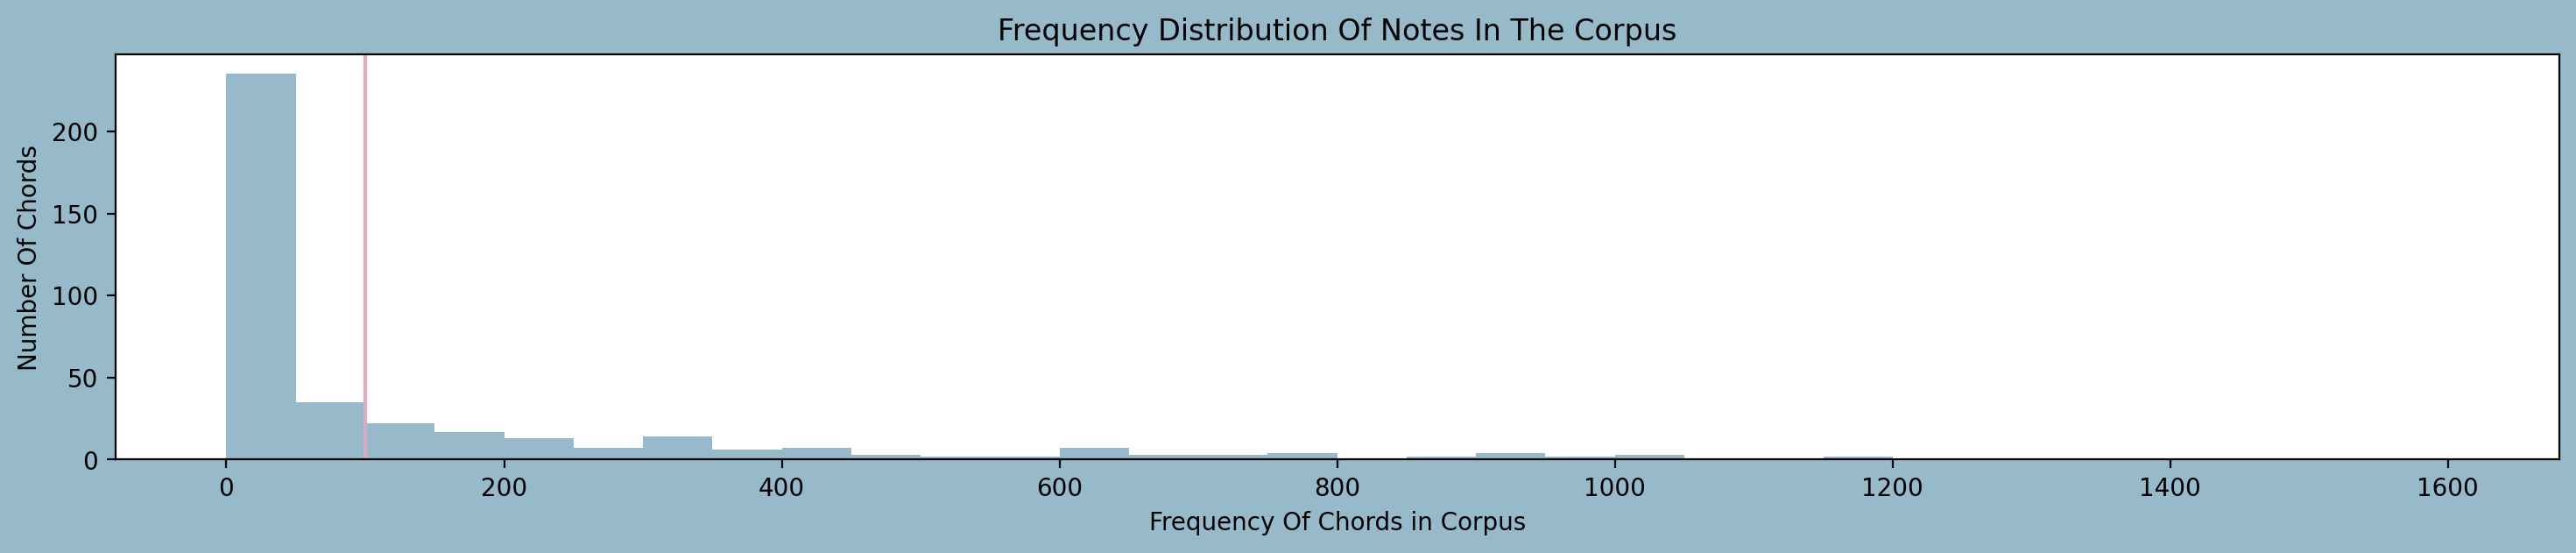

In [10]:
# Plotting the distribution of Notes
plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(Recurrence)), 50)
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=100,color="#DBACC1")
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

In [11]:
#Getting a list of rare chords
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)

print("Total number of notes that occur less than 100 times:", len(rare_note))

Total number of notes that occur less than 100 times: 270


In [12]:
#Eleminating the rare notes
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print("Length of Corpus after elemination the rare notes:", len(Corpus))

Length of Corpus after elemination the rare notes: 53746


In [13]:
# Storing all the unique characters present in my corpus to bult a mapping dic.
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 53746
Number of unique characters: 256


In [14]:
#Splitting the Corpus in equal length of strings and output target
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])


L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 53706


In [15]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets)

In [16]:
#Taking out a subset of data to be used as seed
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
#Initialising the Model
model = Sequential()
#Adding layers
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 40, 512)             │       1,052,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 40, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 256)                 │         787,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,971,712 (7.52 MB)

 Trainable params: 1,971,712 (7.52 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
#Training the Model
history = model.fit(X_train, y_train, batch_size=1028, epochs=5)

Epoch 1/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 511s 12s/step - loss: 5.2212
Epoch 2/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 509s 12s/step - loss: 4.6982
Epoch 3/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 553s 12s/step - loss: 4.6722
Epoch 4/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 510s 12s/step - loss: 4.6489
Epoch 5/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 569s 12s/step - loss: 4.5431


[Text(0.5, 0, 'Epochs')]

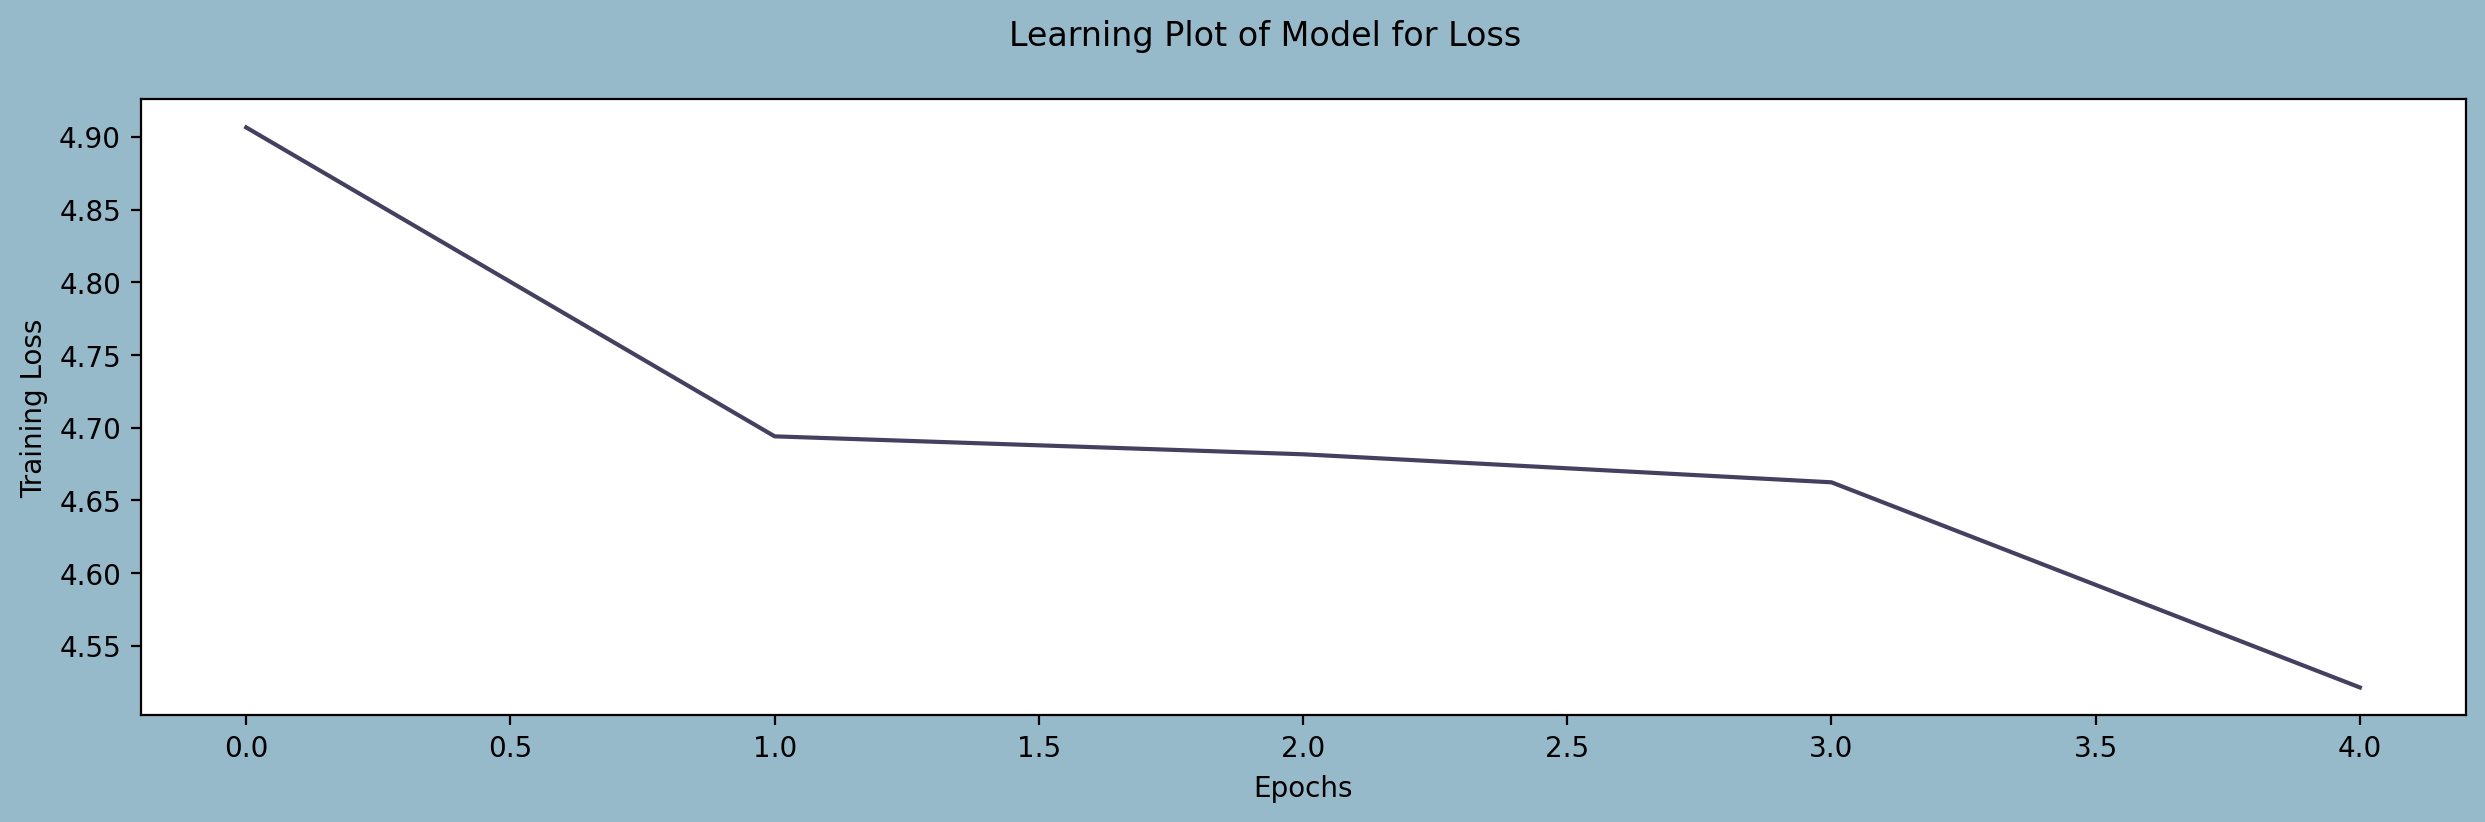

In [20]:
#Plotting the learnings
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4), facecolor="#97BACB")
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

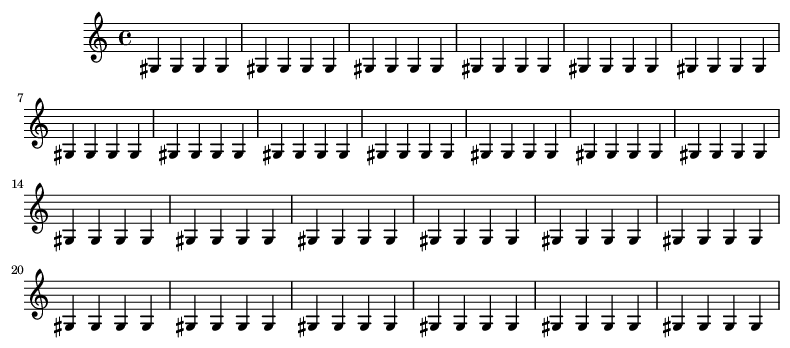

In [21]:
def Malody_Generator(Note_Count):
    seed = X_seed[np.random.randint(0,len(X_seed)-1)]
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = seed.reshape(1,length,1)
        prediction = model.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 #diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(L_symb)
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    #Now, we have music in form or a list of chords and notes and we want to be a midi file.
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)
    return Music,Melody_midi


#getting the Notes and Melody created by the model
Music_notes, Melody = Malody_Generator(100)
show(Melody)

In [23]:
#To save the generated melody
Melody.write('midi','Melody_Generated.mid')
# #to play audio or corpus
# IPython.display.Audio("../input/music-generated-lstm/Melody_Generated 2.wav")

'Melody_Generated.mid'